In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers import nwsim
from helpers.metrics import *
from helpers.metrics import foote_novelty
import matplotlib.gridspec as gridspec

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

In [2]:
dists, dat, coltrans, keys = load()

# Topic Linkage Network Similarity

The emergence of community structure is a sign of specialization. However, to what extent are communities stable over time?

In [3]:
from helpers.metrics import *

In [4]:
communities = {}
networks = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr='pmi')
    cms = nx.algorithms.community.louvain_communities(g, weight='pmi',resolution=1.25)
    networks[str(date)] = g

    for cc,c in enumerate(cms):
        communities[f"{cd}-{cc}"] = c

In [5]:
r = [{"n1": ky1, "n2": ky2,'ovl':overlap_coefficient(c1,c2)}
     for ky1, c1 in communities.items() for ky2, c2 in communities.items() 
     if ky1 != ky2 and len(c1) > 3 and len(c2) > 3]

rd = pd.DataFrame(r)
rd = rd[(rd.n1.str.split('-').str[0].astype(int) + 1 == rd.n2.str.split('-').str[0].astype(int)) & (rd.ovl > .25)]

In [6]:
g = nx.from_pandas_edgelist(df = rd,source='n1',target='n2',create_using=nx.DiGraph())

In [50]:
import random

In [57]:
def filter_subpaths(list_,pb=False):
    non_subpaths = []

    if pb == True:
        for path in tqdm(list_):
            is_subpath = False
            for other_path in list_:
                if path != other_path and path in other_path:
                    is_subpath = True
                    break
            if not is_subpath:
                non_subpaths.append(path)
    else:
        for path in list_:
            is_subpath = False
            for other_path in list_:
                if path != other_path and path in other_path:
                    is_subpath = True
                    break
            if not is_subpath:
                non_subpaths.append(path)
    return non_subpaths

def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def filter_subpaths_in_chunks(all_paths_str, chunk_size=1000, iterations=2):
    current_paths = all_paths_str

    for _ in range(iterations):
        intermediate_results = []
        for chunk in tqdm(chunk_list(current_paths, chunk_size)):
            filtered_chunk = filter_subpaths(chunk)
            intermediate_results.extend(filtered_chunk)
        random.shuffle(intermediate_results)
        current_paths = intermediate_results

    # Final filtering to ensure no subpaths exist in the final list
    final_results = filter_subpaths(current_paths,pb=True)
    return final_results



# Use all_pairs_shortest_path to find all shortest paths between all pairs of nodes
paths_nx = dict(nx.all_pairs_shortest_path(g))

# Convert paths_nx to a list of paths
all_paths = [path for paths_from_source in paths_nx.values() for path in paths_from_source.values() if len(path) >= 8]
all_paths_str = ['_'.join(p) for p in all_paths]

In [60]:
filtered = filter_subpaths_in_chunks(all_paths_str, chunk_size=2000, iterations=6)

155it [00:41,  3.72it/s]
33it [00:15,  2.25it/s]

In [39]:
len(filtered)

81104

In [14]:
# chunk
n = 1000
chunks = [all_paths_str[i:i + n] for i in range(0, len(all_paths_str), n)]

chunk_res = []

for c in tqdm(chunks):
    chunk_res += filter_subpaths(c)

100%|██████████| 310/310 [00:12<00:00, 24.24it/s]


In [15]:
filtered = filter_subpaths(chunk_res)

In [23]:
r = []

for i in chunks[0]:
    is_subpath = False
    for j in chunks[0]:
        if i in j:
            is_subpath = True
            break
        if not is_subpath:
            r.append(i)

In [29]:
len(chunks[0]),len(r)

(1000, 356515)

In [31]:
[p for p in chunks[0] if any(p in _ for _ in chunks[0]) == False]

[]

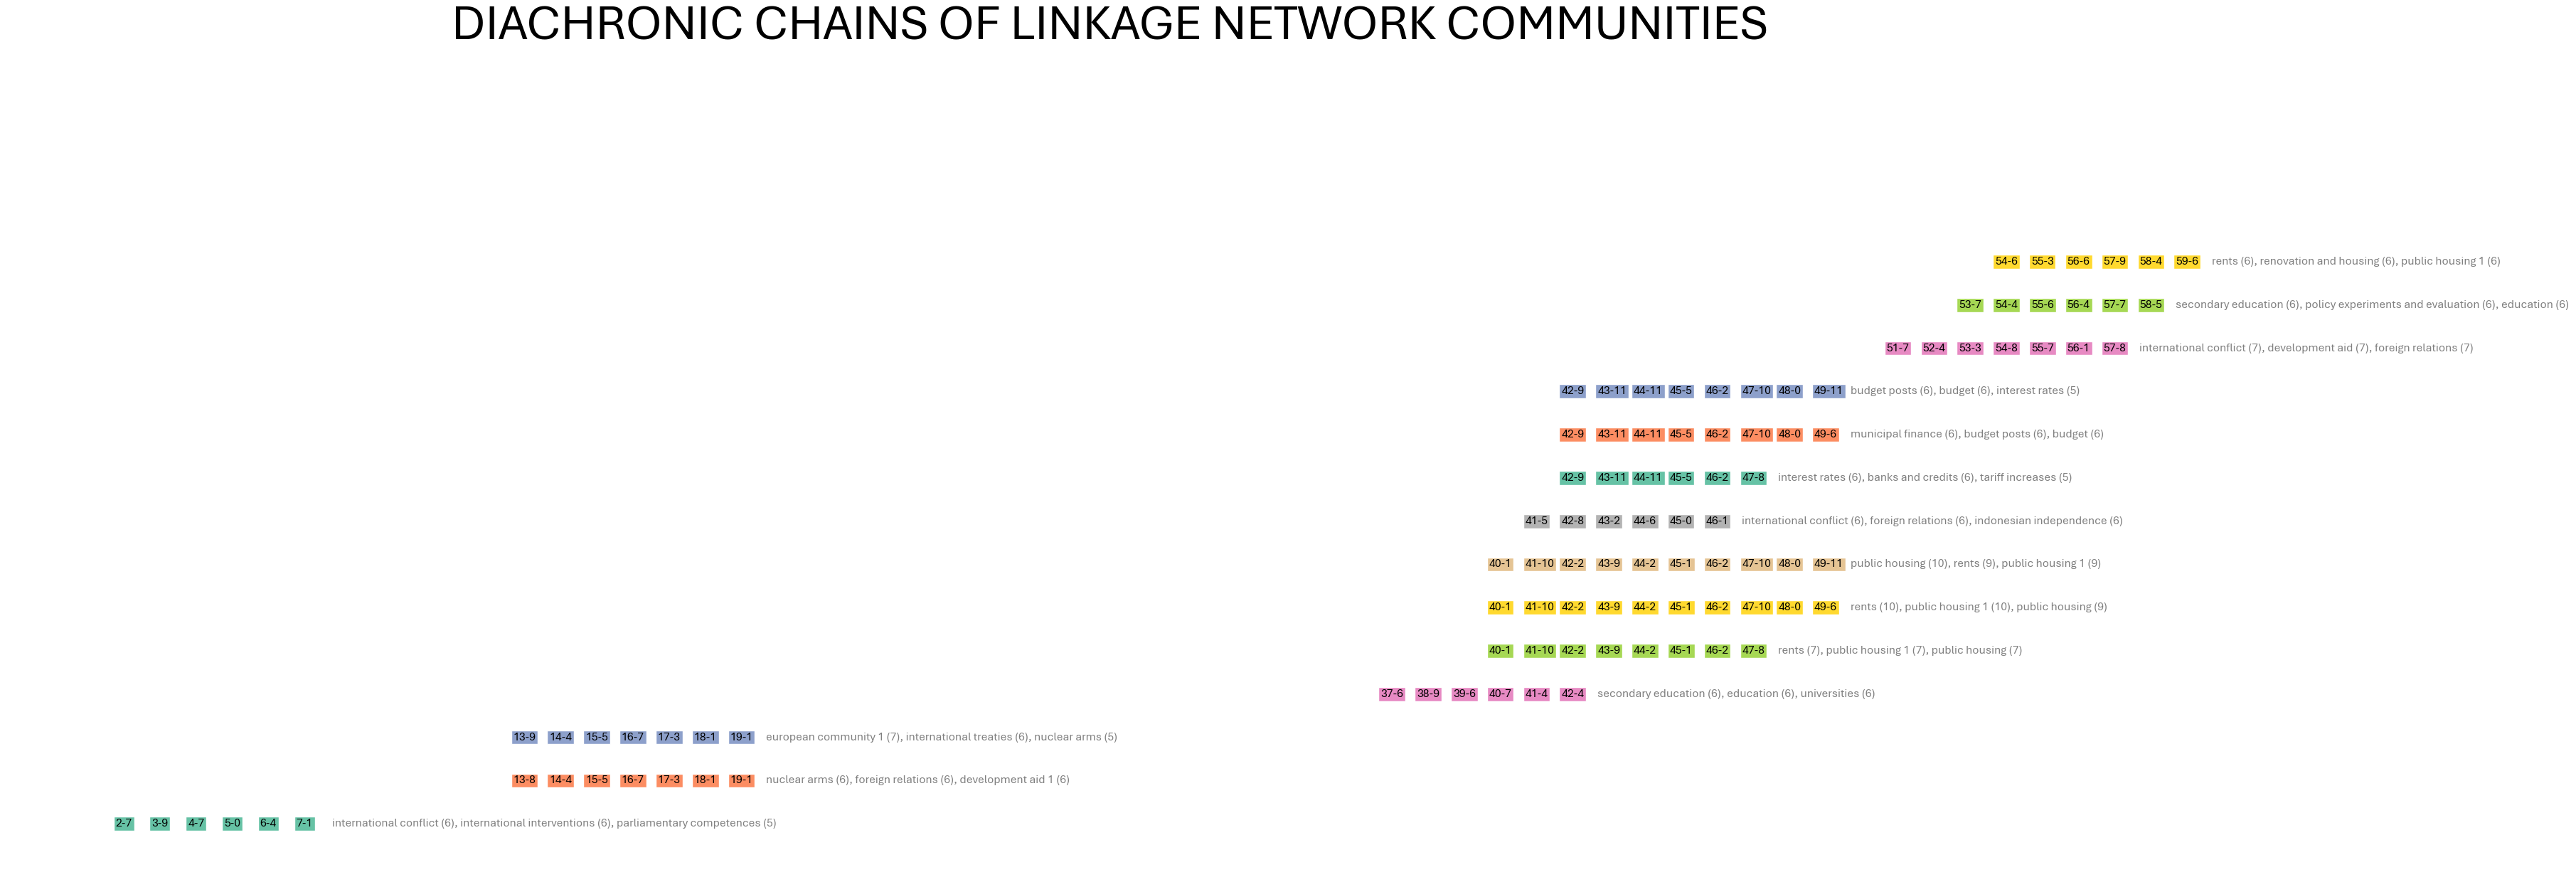

In [120]:
f, a = plt.subplots(figsize=(40,15))

cmap = sns.color_palette('Set2',len(filtered_paths))

for ylevel,chain in enumerate(filtered_paths):

    topics = []
    for node in chain:
        x = int(node.split('-')[0])
        a.annotate(text=node,xy=(x,ylevel),color='black',bbox=dict(facecolor=cmap[ylevel], edgecolor='white', pad=2.0))
        topics += list(communities[node])
    topics = ', '.join([f"{t} ({c})" for t,c in Counter(topics).most_common(3)])
    a.annotate(text=topics,xy=(x + 1,ylevel),color='grey')

a.set_xlim(-1,60)
a.set_ylim(-1,ylevel+1)
a.axis('off')
a.set_title('Diachronic Chains of Linkage Network Communities'.upper(),fontsize=50)
# explanation = """The first number in the node refers to the period, the second to the community ID in that period\nClusters are linked if they have a Jaccard Similarity of > .25\nFor every cluster in period P, its top match in period P+1 is identified.\nAfter the last cluster in the chain, the most frequent topics in the chain are shown."""
# a.annotate(text=explanation,xy=(-.5,2.5),color='black',bbox=dict(facecolor="whitesmoke", edgecolor='black', pad=10.0),fontsize=20)
plt.savefig('/home/rb/Desktop/cluster-chains.png',dpi=350)
plt.show()

In [83]:
rd

,n1,n2,ovl
994,0-1,1-5,0.692308
2959,0-3,1-8,0.750000
12780,1-4,2-9,0.750000
19651,2-1,3-2,0.571429
20630,2-2,3-0,0.545455
...,...,...,...
934875,92-1,93-2,0.642857
937819,92-4,93-3,1.000000
941748,92-8,93-8,0.666667
947641,93-3,94-5,0.800000


In [100]:
def find_chains(df):
  edges = defaultdict(list)
  for _, row in df.iterrows():
      src_period, src_node = map(int, row['n1'].split('-'))
      tgt_period, tgt_node = map(int, row['n2'].split('-'))
      edges[(src_period, src_node)].append((tgt_period, tgt_node))
  
  chains = []
  for node in list(edges.keys()):
    if node[0] == 0:
      def explore_chain(current_path):
        next_nodes = edges.get(current_path[-1], [])
        for next_node in next_nodes:
          new_path = current_path + [next_node]
          if not next_nodes:  # Check for dead end (no outgoing edges)
            chains.append("->".join(map(str, new_path)))
          else:
            explore_chain(new_path)  # Recursive call for connected nodes
      explore_chain([node])
  return chains

In [164]:
def js_chain(chain):
    return np.mean([jaccard_similarity(l1,l2) for l1 in chain for l2 in chain if l1 != l2])

In [176]:
rdc[rdc.n1 == '31-8']

,n1,n2,js
425331,31-8,32-0,0.000000
425332,31-8,32-1,0.000000
425333,31-8,32-2,0.000000
425334,31-8,32-3,0.000000
425335,31-8,32-4,0.000000
425336,31-8,32-5,0.000000
425337,31-8,32-6,0.000000
425338,31-8,32-7,0.000000
425339,31-8,32-8,0.125000
425340,31-8,32-9,0.200000


In [178]:
communities['31-8'],communities['32-13']

({'banks and credits',
  'development aid',
  'development aid 1',
  'economic development',
  'european community',
  'european community 1',
  'foreign relations',
  'inflation',
  'international interventions',
  'labor and corporate democracy'},
 {'budget cuts',
  'civil service salaries',
  'economic development',
  'employment',
  'inflation',
  'labor and corporate democracy',
  'minimum wage',
  'policy-making (general) 1',
  'social partner negotiations',
  'wage policy'})

In [8]:
r = []
for t in set(dists_.columns.map(keys)):
     r += [{"t":t,"p1": p1, "p2": p2,'ovl':jaccard_similarity(set(c1.neighbors(t)),set(c2.neighbors(t)))}
          for p1, c1 in networks.items() for p2, c2 in networks.items() if p1 != p2]

rd = pd.DataFrame(r)

In [9]:
ps = sorted(rd.p1.unique())
rdt=rd[rd.p1.apply(lambda per: ps.index(per)) == rd.p2.apply(lambda per: ps.index(per)) - 1]

In [35]:
rr = []
window = 4
for t,d in rdt.groupby('t'):
    vls = d.ovl.tolist()
    dts = d.p1.tolist()
    for i in range(window,len(d)):
        lb = np.mean(vls[i-window:i])
        rr.append({"t":t,"d":dts[i],"lbv":lb})
rrd = pd.DataFrame(rr)
rrd = rrd[pd.to_datetime(rrd.d,infer_datetime_format=True) < pd.Timestamp(year=1994,month=6,day=1)]

In [41]:
dd = dists.groupby(dists.index.map(new_index_date_mapping)).mean().rolling(5).mean().dropna()
dd.columns = dd.columns.map(keys)
dd = dd[pd.to_datetime(dd.index,infer_datetime_format=True) < pd.Timestamp(year=1994,month=6,day=1)]

In [42]:
dd

,civil code,permits,institutional composition,international arms,education and formation,development aid,received letters,civil service size,water management,municipal politics,...,elections,gas and energy,business climate,banks and credits,social policy,pensions,major appointments,rent increase,policy coordination,marriages
new_index,,,,,,,,,,,,,,,,,,,,,
1949-06-01,0.004061,0.007175,0.005951,0.001851,0.002328,0.001301,0.009311,0.008557,0.012201,0.011342,...,0.007121,0.002205,0.004146,0.008799,0.001258,0.005533,0.009963,0.000697,0.003642,0.007313
1950-01-01,0.003680,0.006624,0.005438,0.002340,0.001860,0.001324,0.009066,0.007436,0.013495,0.011226,...,0.007835,0.002315,0.004334,0.008762,0.001245,0.005349,0.008871,0.001303,0.003581,0.006942
1950-06-01,0.004093,0.006465,0.005262,0.002334,0.001885,0.001354,0.009115,0.008001,0.012468,0.009395,...,0.005052,0.002229,0.004037,0.006275,0.001267,0.005460,0.005498,0.001273,0.003459,0.007757
1951-01-01,0.004326,0.007253,0.005271,0.002536,0.001696,0.001398,0.009035,0.007375,0.013556,0.009290,...,0.006782,0.002085,0.003899,0.006048,0.001260,0.005366,0.005660,0.001298,0.003353,0.007307
1951-06-01,0.004138,0.007403,0.004977,0.002841,0.002136,0.001411,0.008432,0.007412,0.010142,0.009341,...,0.005980,0.002265,0.003854,0.006268,0.001318,0.002694,0.006306,0.001346,0.003377,0.007125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992-01-01,0.002419,0.008891,0.006185,0.003426,0.002882,0.010586,0.026614,0.006410,0.003726,0.006622,...,0.003980,0.003997,0.008288,0.002611,0.004791,0.004499,0.004960,0.004469,0.008141,0.004304
1992-06-01,0.002169,0.008535,0.006091,0.003529,0.002830,0.010017,0.027693,0.005910,0.003501,0.005510,...,0.004312,0.003472,0.008808,0.003103,0.004644,0.004042,0.005469,0.004416,0.008125,0.003556
1993-01-01,0.003442,0.008646,0.006151,0.003582,0.002586,0.008469,0.028394,0.005682,0.003853,0.005419,...,0.006346,0.002649,0.008059,0.003169,0.004419,0.003662,0.005431,0.004938,0.007258,0.004259


In [44]:
rrd.groupby('t').apply(lambda g: np.corrcoef(g.lbv.to_numpy(),dd[g.name].to_numpy())[0,1]).sort_values()

t
municipal politics                -0.691089
norms and criterions              -0.574360
religious communities             -0.543736
agricultural prices and exports   -0.416478
marriages                         -0.374908
                                     ...   
minimum wage                       0.731360
incomes                            0.746086
environmental policy               0.755028
budget cuts                        0.846150
employment                         0.855753
Length: 138, dtype: float64

In [47]:
rrd['d'] = pd.to_datetime(rrd.d,infer_datetime_format=True)

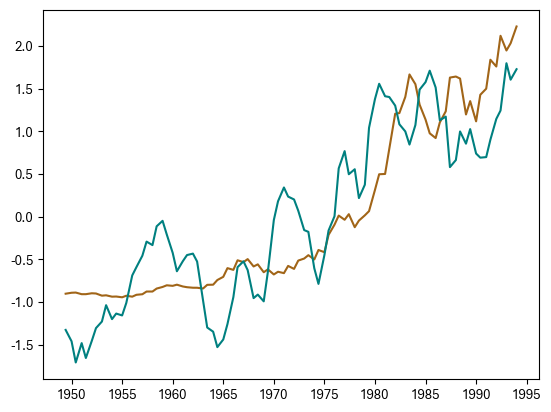

In [57]:
t = 'budget cuts'
f,a = plt.subplots()
a.plot(dd.index,zscore(dd[t]))
ss = rrd[rrd.t == t]
a.plot(ss.d,zscore(ss.lbv),color='teal')

In [52]:
rrd

,t,d,lbv
0,advisory councils,1949-06-01,0.263162
1,advisory councils,1950-01-01,0.225662
2,advisory councils,1950-06-01,0.195482
3,advisory councils,1951-01-01,0.189713
4,advisory councils,1951-06-01,0.211538
...,...,...,...
12415,water management,1992-01-01,0.183749
12416,water management,1992-06-01,0.149120
12417,water management,1993-01-01,0.163009
12418,water management,1993-06-01,0.189567
